In [2]:
!pip install torcheval

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 3.0 MB/s eta 0:00:00


In [3]:
import numpy as np
import torch
import sklearn
import torcheval
from torcheval.metrics import R2Score

np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)

In [6]:
def f(x):
  return (1+x)**(1/2)

a) Computing random labels

In [7]:
N=10000
xs=torch.rand(N)
labels=f(xs)

print(xs,"\n",labels)

tensor([0.8823, 0.9150, 0.3829,  ..., 0.2181, 0.9120, 0.4111]) 
 tensor([1.3720, 1.3838, 1.1760,  ..., 1.1037, 1.3827, 1.1879])


b) Closed form solution

In [8]:
X=torch.concat((torch.ones(N).unsqueeze(1),xs.unsqueeze(1)), dim=1)
print("X matrix", X)

w=(X.t()@X).inverse()@X.t()@labels
print("Weights", w)
print("labels comparison", X@w, labels)

X matrix tensor([[1.0000, 0.8823],
        [1.0000, 0.9150],
        [1.0000, 0.3829],
        ...,
        [1.0000, 0.2181],
        [1.0000, 0.9120],
        [1.0000, 0.4111]])
Weights tensor([1.0131, 0.4116])
labels comparison tensor([1.3763, 1.3898, 1.1707,  ..., 1.1029, 1.3885, 1.1824]) tensor([1.3720, 1.3838, 1.1760,  ..., 1.1037, 1.3827, 1.1879])


c) sklearn linear regression

In [9]:
lin_reg =sklearn.linear_model.LinearRegression()
lin_reg.fit(xs.unsqueeze(1), labels)
y_pred=lin_reg.predict(xs.unsqueeze(1))

print("Weights", lin_reg.coef_)
print("labels comparison", y_pred, labels)
print(sklearn.metrics.r2_score(labels,y_pred))

Weights [0.41161126]
labels comparison [1.3762994 1.3897734 1.1707385 ... 1.1029171 1.3885245 1.1823584] tensor([1.3720, 1.3838, 1.1760,  ..., 1.1037, 1.3827, 1.1879])
0.9980678558349609


d) Grad descent from scratch

In [10]:
xs.requires_grad=True
X.requires_grad=True
def gradient(x, y):
  loss=(y**2-x**2).mean()
  loss.backward()
  return loss.item()

In [11]:
torch.manual_seed(42)

def gradient_descent():
    weights = torch.randn(2, requires_grad=True)
    lr = 0.1
    metric = R2Score()

    for i in range(200):
        y_pred = X @ weights
        loss = torch.mean((y_pred - labels) ** 2)

        loss.backward()

        with torch.no_grad():
            weights -= lr * weights.grad
            weights.grad.zero_()

        if i % 10 == 0:
            metric.reset()
            metric.update(y_pred.squeeze(), labels)
            print("iteration", i, "R^2:", metric.compute().item())
    return weights

weights = gradient_descent()


iteration 0 R^2: -46.76605987548828
iteration 10 R^2: 0.8432192206382751
iteration 20 R^2: 0.9841574430465698
iteration 30 R^2: 0.9876934885978699
iteration 40 R^2: 0.9901065826416016
iteration 50 R^2: 0.9919576644897461
iteration 60 R^2: 0.9933784008026123
iteration 70 R^2: 0.9944687485694885
iteration 80 R^2: 0.995305597782135
iteration 90 R^2: 0.9959478378295898
iteration 100 R^2: 0.9964407682418823
iteration 110 R^2: 0.9968190789222717
iteration 120 R^2: 0.9971094131469727
iteration 130 R^2: 0.9973322749137878
iteration 140 R^2: 0.9975032806396484
iteration 150 R^2: 0.9976345300674438
iteration 160 R^2: 0.997735321521759
iteration 170 R^2: 0.9978126287460327
iteration 180 R^2: 0.9978719353675842
iteration 190 R^2: 0.9979174733161926


e) linear regression using pytorch

In [12]:
class LinearRegression(torch.nn.Module):
  def __init__(self, input_dim, output_dim):
    super().__init__()
    self.linear = torch.nn.Linear(input_dim, output_dim)

  def forward(self, x):
    return self.linear(x)

In [149]:
torch.manual_seed(42)
linreg = LinearRegression(1,1)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(linreg.parameters(), lr=0.001)

metric = R2Score()

for epoch in range(1000):
  y_pred = linreg(xs.unsqueeze(1))
  loss = criterion(y_pred, labels.unsqueeze(1))

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  if epoch % 100 == 0:
    metric.reset()
    metric.update(y_pred, labels.unsqueeze(1))
    print(f"Epoch {epoch} R^2:", metric.compute().item())

Epoch 0 R^2: 0.2613878846168518
Epoch 100 R^2: 0.6081846952438354
Epoch 200 R^2: 0.8119840621948242
Epoch 300 R^2: 0.9195220470428467
Epoch 400 R^2: 0.9691973328590393
Epoch 500 R^2: 0.9889330863952637
Epoch 600 R^2: 0.9955986738204956
Epoch 700 R^2: 0.997500479221344
Epoch 800 R^2: 0.9979574680328369
Epoch 900 R^2: 0.9980497360229492


f) Mini batch from scratch

In [148]:
torch.manual_seed(42)
linreg2 = LinearRegression(1,1)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(linreg2.parameters(), lr=0.001)

metric = R2Score()

indices = torch.randperm(N)
X_batches = torch.split(xs[indices], 32)
labels_batches = torch.split(labels[indices], 32)

for epoch in range(10):
  for x, y in zip(X_batches, labels_batches):
    x = x.detach()
    y = y.detach()

    y_pred = linreg2(x.unsqueeze(1))
    loss = criterion(y_pred, y.unsqueeze(1))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  metric.reset()
  metric.update(y_pred, y.unsqueeze(1))
  print(f"Epoch {epoch} R^2:", metric.compute().item())

Epoch 0 R^2: 0.9162080883979797
Epoch 1 R^2: 0.9965052008628845
Epoch 2 R^2: 0.998451292514801
Epoch 3 R^2: 0.9983261227607727
Epoch 4 R^2: 0.998315691947937
Epoch 5 R^2: 0.9983102083206177
Epoch 6 R^2: 0.9983064532279968
Epoch 7 R^2: 0.9983054995536804
Epoch 8 R^2: 0.9983033537864685
Epoch 9 R^2: 0.9982980489730835


closed form tensor([1.0131, 0.4116])
sklearn tensor([1.0108, 0.4160], requires_grad=True)
scratch Parameter containing:
tensor([[0.4123]], requires_grad=True)
scratch mini batch Parameter containing:
tensor([[0.4122]], requires_grad=True)


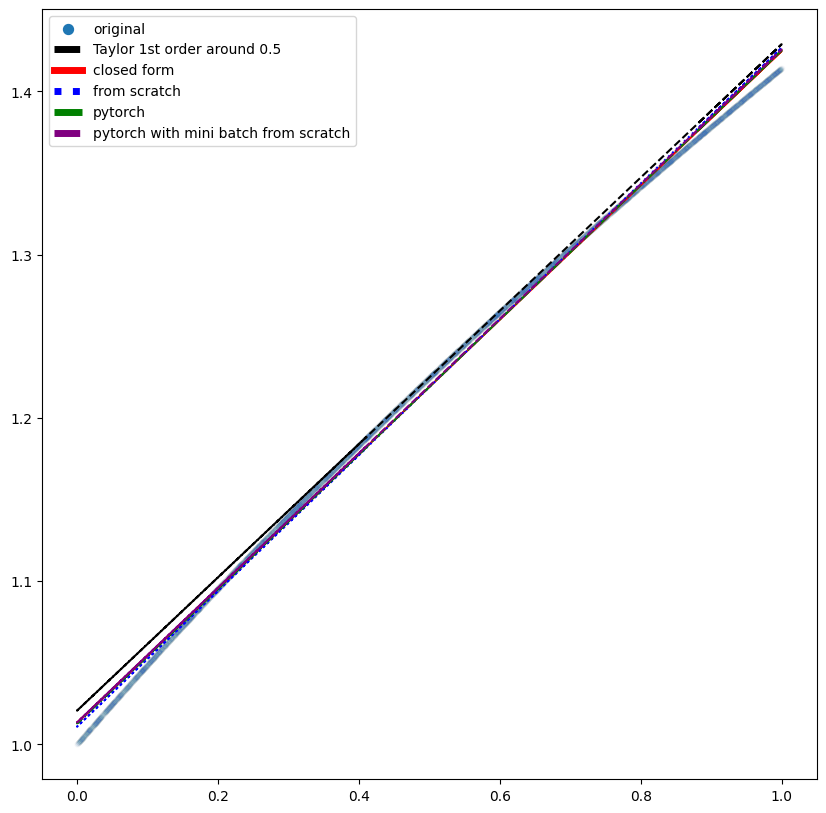

In [150]:
print("closed form", w)
print("sklearn", weights)
print("scratch", linreg.linear.weight)
print("scratch mini batch", linreg2.linear.weight)

import matplotlib.pyplot as plt

fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(10)
xs_np=xs.detach().numpy()

ax.scatter(xs_np, labels.detach().numpy(), alpha=0.01, s=10, label="original data")

taylor = np.sqrt(1+0.5) + (1/(2*np.sqrt(1+0.5))) * (xs_np - 0.5)
ax.plot(xs_np, taylor, label="Taylor 1st order", linestyle="--", color="black")

ax.plot(xs_np, (X@w).detach().numpy(), label="closed form", linestyle="-", color="red")

ax.plot(xs_np, (X@weights).detach().numpy(), label="scratch", linestyle=":", color="blue")

pytorch_full = (xs.unsqueeze(1) @ linreg.linear.weight.t() + linreg.linear.bias).detach().numpy().squeeze()
ax.plot(xs_np, pytorch_full, label="pytorch full", linestyle="-.", color="green")

pytorch_mini = (xs.unsqueeze(1) @ linreg2.linear.weight.t() + linreg2.linear.bias).detach().numpy().squeeze()
ax.plot(xs_np, pytorch_mini, label="pytorch mini-batch", linestyle="--", color="purple")


leg = ax.legend(["original", "Taylor 1st order around 0.5", "closed form", "from scratch", "pytorch", "pytorch with mini batch from scratch"])

for lh in leg.legend_handles:
    lh.set_alpha(1)
    lh.set_linewidth(5)
plt.show()

In [151]:
def mse(x,y):
  return ((x-y)**2).mean()

def taylor(x,a):
  return np.sqrt(1+a)+1/(2*np.sqrt(1+a))*(x-a)

# compare with taylor
print("original", mse(taylor(xs_np, 0.5) , labels.detach().numpy()))
print("closed form", mse(taylor(xs_np, 0.5) , (X@w).detach().numpy()))
print("from scratch", mse(taylor(xs_np, 0.5) , (X@weights).detach().numpy()))
print("pytorch", mse(taylor(xs_np, 0.5) , (xs.unsqueeze(1)@linreg.linear.weight.t()+linreg.linear.bias).detach().numpy()))
print("from scratch mini batch", mse(taylor(xs_np, 0.5) , (xs.unsqueeze(1)@linreg2.linear.weight.t()+linreg2.linear.bias).detach().numpy()))


original 6.180084491972537e-05
closed form 3.445743865107967e-05
from scratch 4.034568084363287e-05
pytorch 0.028095079215837038
from scratch mini batch 0.028087337939371654


# PART 2:
a) download data, keep 20% for testing

In [17]:
# upload dataset
from google.colab import files
uploaded = files.upload()

Saving heart_disease_uci.csv to heart_disease_uci.csv


In [18]:
import pandas as pd

data=pd.read_csv("heart_disease_uci.csv")
y = (data.pop("num") > 0).astype(int)

# 2. Train/test split
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    data, y, test_size=0.2, random_state=42, shuffle=True
)

# 3. preprocessing pipeline
numeric_features = X_train.select_dtypes(include=['int64','float64']).columns
categorical_features = X_train.select_dtypes(include=['object']).columns

# I use only imputer here to remove NaNs, in this case without normalization
numeric_transformer0 = sklearn.pipeline.Pipeline(steps=[
    ('imputer', sklearn.impute.SimpleImputer(strategy='mean')),
])

categorical_transformer0 = sklearn.pipeline.Pipeline(steps=[
    ('imputer', sklearn.impute.SimpleImputer(strategy='most_frequent')),
    ('onehot', sklearn.preprocessing.OneHotEncoder(handle_unknown='ignore'))
])

preprocessor0 = sklearn.compose.ColumnTransformer([
    ('num', numeric_transformer0, numeric_features),
    ('cat', categorical_transformer0, categorical_features)
])

# 4. Fit on training data, transform both
X_train0 = preprocessor0.fit_transform(X_train)
X_test0  = preprocessor0.transform(X_test)

b) Perform logistic regression and try to find the best hyperparameters (using sklearn).

In [19]:
import time
# time now
start = time.time()

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'max_iter': [100, 1000, 10000]
}

logreg = sklearn.linear_model.LogisticRegression(random_state=42)

grid_search = sklearn.model_selection.GridSearchCV(logreg, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train0, y_train)

end = time.time()

print("convergence time", end - start)

print("Best parameters:", grid_search.best_params_)
print("Best cross-val accuracy:", grid_search.best_score_)
print("Test accuracy:", grid_search.score(X_test0, y_test))

convergence time 28.068603992462158
Best parameters: {'C': 1, 'max_iter': 10000}
Best cross-val accuracy: 0.8614175399889685
Test accuracy: 0.8532608695652174


c) Normalize data and run logistic regression again

In [21]:
data=pd.read_csv("heart_disease_uci.csv")
y = (data.pop("num") > 0).astype(int)

# 2. Train/test split
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    data, y, test_size=0.2, random_state=42, shuffle=True
)

# 3. preprocessing pipeline
numeric_features = X_train.select_dtypes(include=['int64','float64']).columns
categorical_features = X_train.select_dtypes(include=['object']).columns

numeric_transformer = sklearn.preprocessing.StandardScaler()
categorical_transformer = sklearn.preprocessing.OneHotEncoder(handle_unknown='ignore')

numeric_transformer = sklearn.pipeline.Pipeline(steps=[
    ('imputer', sklearn.impute.SimpleImputer(strategy='mean')),
    ('scaler', sklearn.preprocessing.StandardScaler())
])

categorical_transformer = sklearn.pipeline.Pipeline(steps=[
    ('imputer', sklearn.impute.SimpleImputer(strategy='most_frequent')),
    ('onehot', sklearn.preprocessing.OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = sklearn.compose.ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# 4. Fit on training data, transform both
X_train = preprocessor.fit_transform(X_train)
X_test  = preprocessor.transform(X_test)

In [21]:
start = time.time()

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'max_iter': [100, 1000, 10000]
}

logreg = sklearn.linear_model.LogisticRegression(random_state=42)

grid_search = sklearn.model_selection.GridSearchCV(logreg, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

end = time.time()
print("convergence time", end - start)

print("Best parameters:", grid_search.best_params_)
print("Best cross-val accuracy:", grid_search.best_score_)
print("Test accuracy:", grid_search.score(X_test, y_test))

convergence time 0.5295095443725586
Best parameters: {'C': 1, 'max_iter': 100}
Best cross-val accuracy: 0.8559845559845559
Test accuracy: 0.8478260869565217


From what we can see, though unnormalized data performed slightly better (0.853 against 0.847), it converged much slower (17 seconds against 0.5 seconds)

d) Try to find the best neural net to solve this problem which will have no more than
2 hidden layers (use sklearn). Without scaling

In [22]:
hidden_layer_sizes = []

for i in range(3,8):
  for j in range(3,8):
    hidden_layer_sizes.append((2**i, 2**j))

param_grid = {
    'hidden_layer_sizes': hidden_layer_sizes
}

classifier = sklearn.neural_network.MLPClassifier(random_state=42, max_iter=100, early_stopping=True)

start = time.time()

grid_search = sklearn.model_selection.GridSearchCV(classifier, param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train0, y_train)

end = time.time()

results_df = pd.DataFrame(grid_search.cv_results_)
sorted_df = results_df.sort_values(by="mean_test_score", ascending=False)

top5 = sorted_df[["mean_test_score", "params"]].head(5)
print(top5.to_string(index=False))

print("convergence time", end - start)
print("Best parameters:", grid_search.best_params_)
print("Best cross-val accuracy:", grid_search.best_score_)
print("Test accuracy:", grid_search.score(X_test0, y_test))

 mean_test_score                             params
        0.764913   {'hidden_layer_sizes': (64, 32)}
        0.752724  {'hidden_layer_sizes': (128, 16)}
        0.749975    {'hidden_layer_sizes': (32, 8)}
        0.744577  {'hidden_layer_sizes': (32, 128)}
        0.744533 {'hidden_layer_sizes': (128, 128)}
convergence time 7.089508771896362
Best parameters: {'hidden_layer_sizes': (64, 32)}
Best cross-val accuracy: 0.7649134450528178
Test accuracy: 0.8097826086956522


With normalization

In [23]:
classifier = sklearn.neural_network.MLPClassifier(random_state=42, early_stopping=True)

start = time.time()

grid_search = sklearn.model_selection.GridSearchCV(classifier, param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

end = time.time()

results_df = pd.DataFrame(grid_search.cv_results_)
sorted_df = results_df.sort_values(by="mean_test_score", ascending=False)

top5 = sorted_df[["mean_test_score", "params"]].head(5)
print(top5.to_string(index=False))

print("convergence time", end - start)
print("Best parameters:", grid_search.best_params_)
print("Best cross-val accuracy:", grid_search.best_score_)
print("Test accuracy:", grid_search.score(X_test, y_test))

 mean_test_score                             params
        0.820679  {'hidden_layer_sizes': (32, 128)}
        0.817975   {'hidden_layer_sizes': (16, 64)}
        0.817969   {'hidden_layer_sizes': (64, 64)}
        0.815237  {'hidden_layer_sizes': (128, 64)}
        0.813899 {'hidden_layer_sizes': (128, 128)}
convergence time 5.825174570083618
Best parameters: {'hidden_layer_sizes': (32, 128)}
Best cross-val accuracy: 0.8206791659753332
Test accuracy: 0.8315217391304348


It's interesting how normalization totally changes the architecture. We can notice that data normalization makes large difference in accuracy for both accuracy (0.728 against 0.858) and convergence time (3.85 and 5.36). Also notice how un-normalized data prefers "wider" network (64,32), though (32,128) again performs well in top 5. A logical assummption can be made that first network is more adapted to extracting raw data. On the contrary, the second one has better data exploration given the data is already "extracted".  

I have also tried changing learning-rate and activation function once, but because of long convergence time I changed the code. In short, smaller learning rates make small difference but not enough to trade-off with time. From sigmoid, tanh and relu, the best performer was always relu.

f) using NN classifier with PyTorch (no more than 2 hidden layers)

In [57]:
# transforming numpy arrays to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

train_dataloader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor), batch_size=32, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor), batch_size=32, shuffle=False)

In [25]:
class Classifier(torch.nn.Module):
  def __init__(self, in_ch, hidden1, hidden2, out_ch):
    super().__init__()

    self.nn = torch.nn.Sequential(
        torch.nn.Linear(in_ch, hidden1), torch.nn.ReLU(),
        torch.nn.Linear(hidden1, hidden2), torch.nn.ReLU(),
        torch.nn.Linear(hidden2, out_ch), torch.nn.ReLU(),
    )

  def forward(self, x):
    return self.nn(x)

In [26]:
def train_classifier(hidden1, hidden2):
  model = Classifier(X_train.shape[1], hidden1, hidden2, y_train.shape[0])
  device = "cuda" if torch.cuda.is_available() else "cpu"
  model.to(device)

  loss_f = torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

  num_epochs = 20

  train_accuracy_last = 0
  val_accuracy_last = 0

  best_validation_score = 0
  best_model = None
  patience = 50
  epochs_without_improvement=0

  for epoch in range(num_epochs):
      train_accuracy = []
      val_accuracy = []

      # train
      model.train()
      for batch in train_dataloader:
        x, y = batch
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        loss = loss_f(y_pred, y.long())

        train_accuracy.append(sklearn.metrics.f1_score(y.detach().cpu().numpy(), torch.argmax(y_pred, dim=1).detach().cpu().numpy(), average='weighted'))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

      train_accuracy_last = np.mean(train_accuracy)

      # test
      model.eval()

      with torch.no_grad():
        for batch in test_dataloader:
          x, y = batch
          x, y = x.to(device), y.to(device)
          y_pred = model(x)
          loss = loss_f(y_pred, y.long())

          val_accuracy.append(sklearn.metrics.f1_score(y.detach().cpu().numpy(), torch.argmax(y_pred, dim=1).detach().cpu().numpy(), average='weighted'))

        val_accuracy_last = np.mean(val_accuracy)

      # early stopping
      if val_accuracy_last > best_validation_score:
        best_validation_score = val_accuracy_last
        best_model = model.state_dict()
        epochs_without_improvement=0
      else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
          print(f"Early stopping triggered at epoch {epoch+1}")
          break

  if best_model is not None:
      model.load_state_dict(best_model)

  # print("hidden layers: ", hidden1, hidden2, "train accuracy", train_accuracy_last, "val accuracy", val_accuracy_last)
  return best_model, train_accuracy_last, val_accuracy_last

In [27]:
best_validation = 0
best_model = None
best_hidden_layers=()

results ={} # train accuracy, validation accuracy, training time

for i in range(3,10):
  for j in range(3,10):
    train_start = time.time()
    model, train_accuracy, val_accuracy = train_classifier(2**i, 2**j)
    train_end = time.time()
    if val_accuracy > best_validation:
      best_validation = val_accuracy
      best_model = model
      best_hidden_layers=(2**i,2**j)
    results[(2**i,2**j)] = (train_accuracy, val_accuracy, train_end-train_start)

best_train = max(results.items(), key=lambda x: x[1][0])
print(f"Best training accuracy: {best_train[1][0]:.4f} at layers {best_train[0]}")

best_val = max(results.items(), key=lambda x: x[1][1])
print(f"Best validation accuracy: {best_val[1][1]:.4f} at layers {best_val[0]}")

fastest = min(results.items(), key=lambda x: x[1][2])
print(f"Fastest model: {fastest[1][2]:.2f}s at layers {fastest[0]}")

for layers, r in sorted(results.items(), key=lambda x: x[1][1], reverse=True):
  print(f"Layers: {layers}, Train accuracy: {r[0]:.4f}, Val accuracy: {r[1]:.4f}, Training time {r[2]:.4f}")

Best training accuracy: 0.9795 at layers (512, 64)
Best validation accuracy: 0.8713 at layers (8, 256)
Fastest model: 2.80s at layers (64, 16)
Layers: (8, 256), Train accuracy: 0.8906, Val accuracy: 0.8713, Training time 4.9603
Layers: (8, 64), Train accuracy: 0.8726, Val accuracy: 0.8710, Training time 3.1099
Layers: (512, 16), Train accuracy: 0.9494, Val accuracy: 0.8653, Training time 2.9242
Layers: (64, 64), Train accuracy: 0.9197, Val accuracy: 0.8651, Training time 3.1110
Layers: (16, 256), Train accuracy: 0.9049, Val accuracy: 0.8636, Training time 4.5799
Layers: (16, 16), Train accuracy: 0.8676, Val accuracy: 0.8636, Training time 3.4935
Layers: (512, 64), Train accuracy: 0.9795, Val accuracy: 0.8630, Training time 4.1472
Layers: (128, 512), Train accuracy: 0.9606, Val accuracy: 0.8628, Training time 6.1067
Layers: (128, 16), Train accuracy: 0.9152, Val accuracy: 0.8625, Training time 2.8857
Layers: (8, 8), Train accuracy: 0.8474, Val accuracy: 0.8616, Training time 2.9262
Laye

Best training accuracy: (512, 64), Train accuracy: 0.9795, Val accuracy: 0.8630, Training time 4.1472.  

Best validation accuracy: (8, 256), Train accuracy: 0.8906, Val accuracy: 0.8713, Training time 4.9603  

Fastest model: (64, 16), Train accuracy: 0.3860, Val accuracy: 0.4425, Training time 2.7956.

Sadly, as much as I tried to make an analysis of the results, most of the time they're quite different. For example, in one case I got the best validation accuracy being (64,8), which is the complete opposite of what we see now (8,256). This means that NN is highly dependent on the initial conditions. On the other hand, large first layer is almost always the best at training and thus at overfitting.  

Though (64,16) had faster training rate, it's one of the worst performers.

g) Compare accuracies of all obtained models.

In [38]:
# after finding out that (8, 256) performs the best
# I runned several cases to find the best random initialization and avoid local minimums

best_model = None
best_val = 0.0
for _ in range(10):
  model, train_accuracy, validation_accuracy = train_classifier(8,256)
  print(train_accuracy, validation_accuracy)
  if validation_accuracy > best_val:
    best_model=model
    best_val = validation_accuracy

print(best_val)

0.8750490556892412 0.7142829567909953
0.866137568080054 0.7745868178293094
0.8809522752232866 0.8584970285236512
0.8983027319515289 0.8343140643127982
0.8818186656946991 0.8322006707257681
0.8743338581990613 0.8257042517750621
0.9031417185004776 0.8368776398747583
0.2914646009729163 0.23938574610222188
0.29067773103139855 0.23938574610222188
0.2909435490891994 0.23938574610222188
0.8584970285236512


Right now there are  

1) logistic regression without normalization 0.853, time 28.06s  
2) logistic regression with normalization 0.847, time 0.529s  
3) scikit learn nn without normalization 0.809, time 7.0s  
4) scikit learn nn with normalization 0.831, time 5.82s  
5) pytorch best model 0.858, time 4.9s  

Which is quite interesting that simple logistic regression with normalization performs almost as well as pytorch NN. We can also notice from this data that normalization increases convergence time in general.

h) Retrain your best-performing model using PyTorch Lightning. Incorporate a logger
to track your experiments and use a learning rate scheduler.

In [40]:
import lightning as pl

In [84]:
class LitClassifier(pl.LightningModule):
    def __init__(self, input_size, hidden1, hidden2, output_size, lr=1e-2):
        super().__init__()
        self.save_hyperparameters()
        self.model = torch.nn.Sequential(
            torch.nn.Linear(input_size, hidden1),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden1, hidden2),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden2, output_size)
        )
        self.loss_f = torch.nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x.float())

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.01)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
        return [optimizer], [scheduler]

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self.loss_f(y_pred, y.long())
        preds = torch.argmax(y_pred, dim=1)
        acc = sklearn.metrics.f1_score(y.cpu(), preds.cpu(), average='weighted')
        self.log("train_loss", loss, prog_bar=True)
        self.log("train_f1", acc, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self.loss_f(y_pred, y.long())
        preds = torch.argmax(y_pred, dim=1)
        acc = sklearn.metrics.f1_score(y.cpu(), preds.cpu(), average='weighted')
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_f1", acc, prog_bar=True)


In [85]:
pl_model = LitClassifier(X_train.shape[1], 8, 256, y_train.shape[0])

trainer = pl.Trainer(
    max_epochs=25,
    logger=pl.pytorch.loggers.tensorboard.TensorBoardLogger(save_dir="logs/"),
    callbacks=[pl.pytorch.callbacks.ModelCheckpoint(monitor="val_f1", mode="max")],
    deterministic=True
)

trainer.fit(pl_model, train_dataloader, test_dataloader)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: 
  | Name   | Type             | Params | Mode 
----------------------------------------------------
0 | model  | Sequential       | 191 K  | train
1 | loss_f | CrossEntropyLoss | 0      | train
----------------------------------------------------
191 K     Trainable params
0         Non-trainable params
191 K     Total params
0.767     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name   | Type             | Params | Mode 
----------------------------------------------------
0 | model  | Sequential       | 191 K  | train
1 | loss_f | CrossEntropyLoss | 0      | train
----------------------------------------------------
191 K     Trainabl

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=25` reached.


Lightning model achieved 0.85 validation accuracy